# Train without normalize

This notebook will use the KuHar view (balanced_motionsense_equivalent_view) and will:

1. Apply DFT over dataset windows
2. Train three times with RF, SVM and KNN, and take the average accuracy and f1-score
3. Plot UMAP and T-SNE

In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
# from sklearn.manifold import TSNE

import plotly.express as px
import plotly.graph_objects as go

from librep.datasets.har.loaders import (
    KuHar_BalancedView20HzMotionSenseEquivalent,
    MotionSense_BalancedView20HZ,
    WISDM_UnbalancedView20Hz,
    UCIHAR_UnbalancedView20Hz
)
from librep.datasets.multimodal import TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
# from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
# from librep.metrics.report import ClassificationReport
# from librep.transforms.resampler import SimpleResampler

2022-11-26 22:13:55.409287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-26 22:13:55.409309: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Dataset

In [3]:
def load_data(data_load, dataset_path):
    loader = data_load(dataset_path, download=False)
    train_val, test = loader.load(concat_train_validation=True, label="standard activity code")

    return train_val, test

In [4]:
def plot(df, figsize: tuple = (5, 5), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label, s=3)
    ax.legend()
    plt.title(title)
    plt.show()

def interactive_plot(df, max_x, max_y, min_x, min_y, file_name,
         hovertext: str = 'label - str', title: str = None, labels: dict = None, legend_title: str = 'Dataset'):

    fig = go.Figure()
    for key, sub_def in df.groupby('label'):
        fig.add_trace(
            go.Scatter (
                x=sub_def['x'],
                y=sub_def['y'],
                name=labels[key],       # this sets its legend entry
                mode='markers',
                marker={'size': 4, 'color':'black'} if key == 'all' else {'size': 4},
                hovertext=sub_def[hovertext]
                # "standard activity code"
                # color='gray',
            )
        )
    fig.update_xaxes(range = [min_x,max_x])
    fig.update_yaxes(range = [min_y,max_y])

    fig.update_layout (
        title={
            'text': title,
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="X",
        yaxis_title="Y",
        legend_title=legend_title,
        template='plotly_white', 
        # template='ggplot2', 

        # You can see another thems on https://plotly.com/python/templates/        
        # Templates configuration
        # -----------------------
        #     Default template: 'plotly'
        #     Available templates:
        #         ['ggplot2', 'seaborn', 'simple_white', 'plotly',
        #          'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
        #          'ygridoff', 'gridon', 'none']

        width=900,
        height=900,
        font=dict(
            # family="Courier New, monospace",
            size=15,
            # color="RebeccaPurple"
        )
    )

    # fig.show()
    # fig.write_image(f"pdfFile/{file_name}.pdf")
    # fig.write_image(f"pngFile/{file_name}.png")
    # fig.write_image(f"Charts/{file_name}.svg")
    fig.write_html(f"htmlFile/{file_name}.html")
    # fig.write_json(f"jsonFile/{file_name}.json")


In [5]:
datasets = {
    'KuHar': {
        'loader': KuHar_BalancedView20HzMotionSenseEquivalent,
        'Path': "../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1"
    },
    'MotionSense': {
        'loader': MotionSense_BalancedView20HZ,
        'Path': "../../data/views/MotionSense/balanced_20Hz_filtered"
    },
    'WISDM': {
        'loader': WISDM_UnbalancedView20Hz,
        'Path': "../../data/views/WISDM/balanced_20Hz_filtered"
    },
    
    'UCI': {
        'loader': UCIHAR_UnbalancedView20Hz,
        'Path': "../../data/views/UCI-HAR/balanced_20Hz_filtered"
    }
}

labels = {
    -1: "all",
    0: "sit",
    1: "stand",
    2: "walk",
    3: "stair up",
    4: "stair down",
    5: "run",
    6: "stair up and down"
}

artifial_label = {key+7:labels[key]+' - artificial' for key in labels.keys() if key>=0}
    
all_labels = {}
all_labels.update(labels)
all_labels.update(artifial_label)
all_labels

{-1: 'all',
 0: 'sit',
 1: 'stand',
 2: 'walk',
 3: 'stair up',
 4: 'stair down',
 5: 'run',
 6: 'stair up and down',
 7: 'sit - artificial',
 8: 'stand - artificial',
 9: 'walk - artificial',
 10: 'stair up - artificial',
 11: 'stair down - artificial',
 12: 'run - artificial',
 13: 'stair up and down - artificial'}

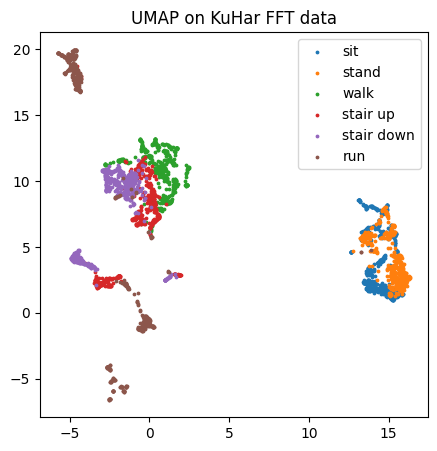

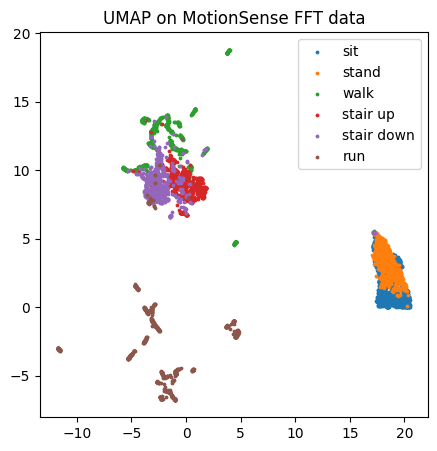

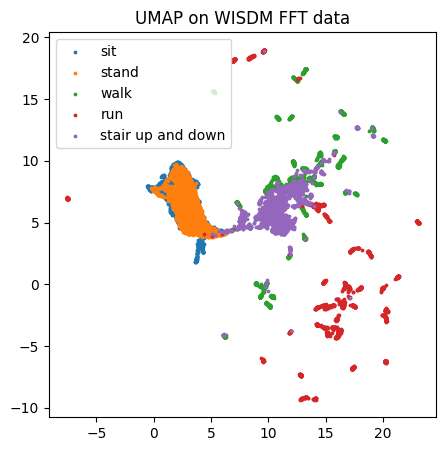

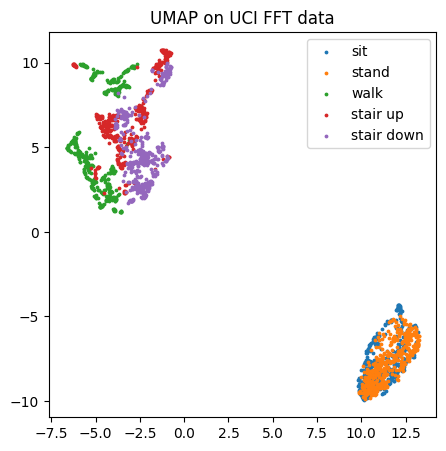

In [6]:
# Create the objects
fft_transform = FFT(centered=True)

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform], new_window_name_prefix="fft."
)

for dataset in datasets.keys():
    loader = datasets[dataset]['loader']
    path = datasets[dataset]['Path']

    train_val, test = load_data(loader, path)
    train_val.data['standard activity code'] = train_val.data['standard activity code'].astype(int)
    test.data['standard activity code'] = test.data['standard activity code'].astype(int)

    # Transform it and generate a new dataset!
    train_val_fft = transformer(train_val)
    test_fft = transformer(test)

    model = UMAP(n_components=2)
    result = pd.DataFrame(model.fit_transform(train_val_fft[:][0]), columns=["x", "y"])
    result["label"] = train_val_fft[:][1]
    y_str = np.array([labels[y] for y in train_val_fft[:][1]])
    result['label - str'] = y_str

    plot(result, title=f"UMAP on {dataset} FFT data", labels = labels)

    min_x, max_x = min(result['x']), max(result['x'])
    min_y, max_y = min(result['y']), max(result['y'])

    corners = np.array([
        [min_x, min_y],
        [min_x, max_y],
        [max_x, min_y],  
        [max_x, max_y]
    ])

    test_pts = np.array([
        (corners[0]*(1-x) + corners[1]*x)*(1-y) +
        (corners[2]*(1-x) + corners[3]*x)*y
        for y in np.linspace(0, 1, 50)
        for x in np.linspace(0, 1, 50)
    ])

    new_df = pd.DataFrame()
    new_df['x'] = test_pts[:,0]
    new_df['y'] = test_pts[:,1]

    rf = RandomForestClassifier()
    rf.fit(train_val_fft[:][0], train_val_fft[:][1])

    test_pts2 = model.inverse_transform(test_pts)
    pred = rf.predict(test_pts2)

    new_df['label'] = pred+7

    pred_str = np.array([artifial_label[y] for y in pred+7])
    new_df['label - str'] = pred_str
    new_df2 = pd.concat([result, new_df], axis=0)

    tam = new_df2['label'].shape[0]
    y = np.array([-1]*tam)
    new_df3 = new_df2.copy()
    new_df3['label'] = y
    new_df4 = pd.concat([new_df2, new_df3], axis=0)
    file_name=f"umap_inverse_{dataset}"

    interactive_plot(new_df4, max_x, max_y, min_x, min_y, file_name,title=f"UMAP on {dataset} FFT data", labels = all_labels)

In [7]:
# Create the objects
fft_transform = FFT(centered=True)

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform], new_window_name_prefix="fft."
)

for dataset in datasets.keys():
    loader = datasets[dataset]['loader']
    path = datasets[dataset]['Path']

    train_val, test = load_data(loader, path)
    train_val.data['standard activity code'] = train_val.data['standard activity code'].astype(int)
    test.data['standard activity code'] = test.data['standard activity code'].astype(int)

    # Transform it and generate a new dataset!
    train_val_fft = transformer(train_val)
    test_fft = transformer(test)

    model = UMAP(n_components=2)
    result = pd.DataFrame(model.fit_transform(train_val_fft[:][0]), columns=["x", "y"])
    result["label"] = train_val_fft[:][1]
    y_str = np.array([labels[y] for y in train_val_fft[:][1]])
    result['label - str'] = y_str

    # plot(result, title=f"UMAP on {dataset} FFT data", labels = labels)

    min_x, max_x = min(result['x']), max(result['x'])
    min_y, max_y = min(result['y']), max(result['y'])

    corners = np.array([
        [min_x, min_y],
        [min_x, max_y],
        [max_x, min_y],  
        [max_x, max_y]
    ])

    train_pts = np.array([
        (corners[0]*(1-x) + corners[1]*x)*(1-y) +
        (corners[2]*(1-x) + corners[3]*x)*y
        for y in np.linspace(0, 1, 50)
        for x in np.linspace(0, 1, 50)
    ])

    rf = RandomForestClassifier()
    rf.fit(train_val_fft[:][0], train_val_fft[:][1])

    test_pts2 = model.inverse_transform(test_pts)
    pred = rf.predict(test_pts2)

    test_pts = model.transform(test_pts2)
    new_df = pd.DataFrame()
    new_df['x'] = test_pts[:,0]
    new_df['y'] = test_pts[:,1]
    new_df['label'] = pred+7

    pred_str = np.array([artifial_label[y] for y in pred+7])
    new_df['label - str'] = pred_str
    new_df2 = pd.concat([result, new_df], axis=0)

    tam = new_df2['label'].shape[0]
    y = np.array([-1]*tam)
    new_df3 = new_df2.copy()
    new_df3['label'] = y
    new_df4 = pd.concat([new_df2, new_df3], axis=0)
    file_name=f"umap_inverse_{dataset}_inverse_reduction"

    interactive_plot(new_df4, max_x, max_y, min_x, min_y, file_name,title=f"UMAP on {dataset} FFT data", labels = all_labels)